In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [4]:
seed = 312

import random
np.random.seed(seed)
random.seed(seed)

In [5]:
from simulate import data_config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data, display_scores, plot_slice_scores

In [6]:
def generate_uniform_circle_data(n, center, radius):
    length = np.sqrt(np.random.uniform(0, 1, n)) * radius
    angle = np.pi * np.random.uniform(
        0, 2, n
    )  # cover full range from 0 to 2pi
    x = length * np.cos(angle) + center[0]
    y = length * np.sin(angle) + center[1]
    return np.vstack((x, y)).T

def get_circle_idx(X, center, radius):
    h, k = center
    idx = np.sqrt((X[:, 0] - h) ** 2 + (X[:, 1] - k) ** 2) < radius
    return idx

def radius_for_lf_metric(target_val, slice_radius, metric=None):
    assert isinstance(slice_radius, int) or isinstance(slice_radius, float)

    if metric == 'recall':
        return np.sqrt(target_val * (slice_radius**2))
    elif metric == 'precision':
        return np.sqrt((slice_radius**2) / target_val)
    else: 
        return slice_radius

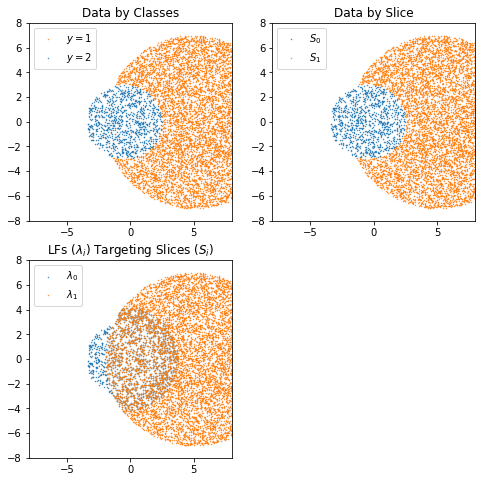

In [7]:
from synthetics_utils import shuffle_matrices, lf_circ_idx_for_slice_precision

config = {
    'N': 10000,
    'mus': np.array([[-0.5,  0], [5, 0]]),
    'variances': [3, 7],
#  'mus': np.array([[0.5,  0], [5, 0]]),
#  'variances': [2.2, 7],
    'labels': [2, 1],
    'props': [0.1, 0.9],
    'lf_metrics': [('recall', 1.0), ('recall', 1.0)],
}

def generate_simple_data(config, x_var=None, x_val=None, verbose=False, return_overlap=False):        
    centers = config['mus']
    radii = config['variances']
    class_props = config['props']
    N = config['N']
    labels = config['labels']
    lf_metrics = config['lf_metrics']    

    # overwrite recall value for head lf
    if x_var == 'slice_proportion': # slice proportion
        class_props[0] = x_val
        class_props[1] = 1 - x_val
        
    elif x_var == 'head_recall':
        target_metric = 'recall'
        lf_metrics[0] = ('recall', x_val)        
        
    # override head precision value
#     head_precision_override = None
    if x_var == 'head_precision':
        target_metric = 'precision'
#         head_precision_override = x_val
        lf_metrics[0] = ('precision', x_val)
    
    # Set slice 1
    n_per_slice = [int(N*prop) for prop in class_props]
    slice_1 = generate_uniform_circle_data(
        n_per_slice[1], 
        centers[1], 
        radii[1]
    )

    # get idx for slice 0 within slice 1
    slice_0_idx = get_circle_idx(slice_1, tuple(centers[0]), radii[0])
    
    # remove slice 0 idx from slice 1
    # NOTE: because we remove the slice, if the variances are not 
    # proportional to the slice size, the original props will not be maintained
    slice_1 = slice_1[np.logical_not(slice_0_idx)]
    n_per_slice[1] = len(slice_1)

    # Set slice 0
    slice_0 = generate_uniform_circle_data(
        n_per_slice[0], 
        centers[0], 
        radii[0]
    )

    # combine slices
    Xu = [slice_0, slice_1] # data points
    Yu = [label * np.ones(n) for n, label in zip(n_per_slice, labels)] # class labels
    Cu = [i * np.ones(n) for i, n in enumerate(n_per_slice)] # slice labels

    X, Y, C = shuffle_matrices([np.vstack(Xu), np.hstack(Yu), np.hstack(Cu)])
    
    # generate label matrix
    L = np.zeros((sum(n_per_slice), 2))

    # set LF0 to target slice 0
    lf0_target_metric, lf0_target_value = lf_metrics[0]
    lf_0_idx = get_circle_idx(
        X, 
        tuple(centers[0]), 
        radius_for_lf_metric(lf0_target_value, radii[0], metric=lf0_target_metric)
    )
    
#     if head_precision_override:
#         lf_0_idx = lf_circ_idx_for_slice_precision(
#             x_val, X, C==0, tuple(centers[0]), radii[0], verbose=True
#         )
    
    L[lf_0_idx, 0] = labels[0]
    
    # set LF1 to target slice 1
    lf1_target_metric, lf1_target_value = lf_metrics[1]
    lf_1_idx = get_circle_idx(
        X, 
        tuple(centers[1]), 
        radius_for_lf_metric(lf1_target_value, radii[1], metric=lf1_target_metric)
    )
    
    L[lf_1_idx, 1] = labels[1]

    overlap_idx = np.logical_and(lf_0_idx, lf_1_idx)
    
    if return_overlap:
        return X, Y, C, L, overlap_idx
    
    return X, Y, C, L

X, Y, C, L, overlap_idx = generate_simple_data(
    config,
    x_var='head_precision',
    x_val=0.5,
    return_overlap=True
)

# mask = C==1
mask = overlap_idx
# X = X[mask]
# Y = Y[mask]
# L = L[mask]
# C = C[mask]

visualize_data(X, Y, C, L)

In [8]:
np.unique(L, return_counts=True), np.unique(Y, return_counts=True)

((array([0., 1., 2.]), array([7033, 8509, 1908])),
 (array([1., 2.]), array([7725, 1000])))

In [9]:
np.unique(L.sum(axis=1), return_counts=True)

(array([1., 2., 3.]), array([6817,  216, 1692]))

In [10]:
X = torch.from_numpy(X.astype(np.float32))

In [11]:
from simulate import simulate, experiment_config
train_end_idx = int(len(X) * experiment_config["train_prop"])
dev_end_idx = train_end_idx + int(len(X) * experiment_config["dev_prop"])

L = L.astype(np.float32)
Y = Y.astype(np.float32)
X_train, X_dev, X_test = X[:train_end_idx], X[train_end_idx:dev_end_idx], X[dev_end_idx:]
Y_train, Y_dev, Y_test = Y[:train_end_idx], Y[train_end_idx:dev_end_idx], Y[dev_end_idx:]
C_train, C_dev, C_test = C[:train_end_idx], C[train_end_idx:dev_end_idx], C[dev_end_idx:]
L_train, L_dev, L_test = L[:train_end_idx], L[train_end_idx:dev_end_idx], L[dev_end_idx:]

overlap_train, overlap_dev, overlap_test = overlap_idx[:train_end_idx], overlap_idx[train_end_idx:dev_end_idx], overlap_idx[dev_end_idx:]

[0.5074626865671642, 0.9058823529411765]


(array([ 157.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 5950.]),
 array([0.48507795, 0.50188605, 0.51869415, 0.53550224, 0.55231034,
        0.56911844, 0.58592654, 0.60273463, 0.61954273, 0.63635083,
        0.65315893, 0.66996702, 0.68677512, 0.70358322, 0.72039132,
        0.73719941, 0.75400751, 0.77081561, 0.78762371, 0.8044318 ,
        0.8212399 , 0.838048  , 0.85485609, 0.87166419, 0.88847229,
        0.90528039, 0.92208848, 0.93889658, 0.95570468, 0.97251278,
        0.98932087]),
 <a list of 30 Patch objects>)

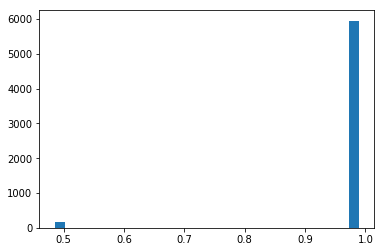

In [13]:
from metal.contrib.slicing.experiment_utils \
    import compute_lf_accuracies
accs = compute_lf_accuracies(L_dev, Y_dev)
print (accs)

# accs = np.array([0.9, 0.1]).astype(np.float32)
from metal.contrib.slicing.experiment_utils import generate_weak_labels
Y_tilde_accs = generate_weak_labels(L_train, np.array(accs))
plt.hist(Y_tilde_accs[:, 0], 30)

(array([ 157.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1172.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 4778.]),
 array([0.33932993, 0.34734769, 0.35536546, 0.36338323, 0.37140099,
        0.37941876, 0.38743652, 0.39545429, 0.40347205, 0.41148982,
        0.41950758, 0.42752535, 0.43554311, 0.44356088, 0.45157864,
        0.45959641, 0.46761417, 0.47563194, 0.4836497 , 0.49166747,
        0.49968523, 0.507703  , 0.51572076, 0.52373853, 0.53175629,
        0.53977406, 0.54779182, 0.55580959, 0.56382736, 0.57184512,
        0.57986289]),
 <a list of 30 Patch objects>)

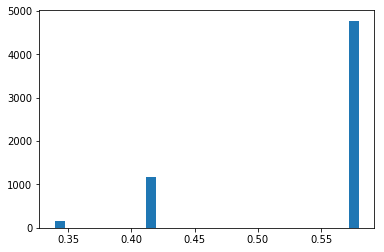

In [14]:
Y_tilde_metal = generate_weak_labels(L_train)
plt.hist(Y_tilde_metal[:, 0], 30)

### Validating that we can reproduce the L matrix 
Train attention model with `slice_weight=1.0`. Then, try to repredict the `L_test` values using the `L_head`.

In [15]:
from metal.end_model import EndModel
from metal.contrib.slicing.online_dp import LinearModule, MLPModule, SliceDPModel

model_configs = {
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 1.0, # NOTE: slice weight 1.0 means we are only backprop on L_head
            "L_weights": None
        },
#         "input_module_class": LinearModule,
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
    }
}

In [16]:
from simulate import train_models

# DEBUG: gt labels for training [prob_1, prob2]
Y_cat = np.zeros((Y_train.shape[0], 2))
Y_cat[:,0] = Y_train == 1
Y_cat[:,1] = Y_train == 2
Y_cat = Y_cat.astype(np.float32)

config['accs'] = np.array(accs)
# config['accs'] = np.array([1.0, 1.0])
experiment_config['use_weak_labels_from_gen_model'] = True
experiment_config['x_var'] = None
experiment_config['num_trials'] = 1
experiment_config['verbose'] = True
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 20
experiment_config['seed'] = 222

trained_models = train_models(
    X_train,
    L_train,
    Y_tilde_accs,
    (X_test, Y_test),
    model_configs,
    experiment_config["train_kwargs"],
    verbose=experiment_config["verbose"],
    seed=experiment_config.get("seed", None)
)


---------- Training AttentionModel ----------
Slice Heads:
Reweighting: True
L_weights: tensor([[1.],
        [1.]])
Slice Weight: 1.0
Input Network: Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
)
L_head: Linear(in_features=5, out_features=2, bias=False)
Y_head: Linear(in_features=10, out_features=2, bias=False)
Criteria: BCEWithLogitsLoss() SoftCrossEntropyLoss()
No checkpoints will be saved in the first checkpoint_runway=5 iterations.


Process Process-1:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    return self._poll(timeout)
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/usr/local/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/local/lib/python3.6/selectors.py", line 376, in sel

RuntimeError: DataLoader worker (pid 3949) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.

In [ ]:
from metal.metrics import accuracy_score
import torch.nn.functional as F
# X_test_L_head = X_train
# L_test_L_head = L_train
# overlap_test_L_head = overlap_train

X_test_L_head = X_test
L_test_L_head = L_test
overlap_test_L_head = overlap_test


slice_preds = F.sigmoid(
    trained_models['AttentionModel'].forward_L(X_test_L_head)
).detach().numpy()


preds = (slice_preds > 0.5) * 1
L_gt = L_test_L_head.copy()
L_gt[L_gt != 0] = 1
print ('predicted L distribution:', np.sum(preds, axis=0))
print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))

print ('accuracy over overlap for LF 0:', 
       accuracy_score(L_gt[overlap_test_L_head, 0], preds[overlap_test_L_head, 0]))

print ('accuracy over overlap for LF 1:', 
      accuracy_score(L_gt[overlap_test_L_head, 1], preds[overlap_test_L_head, 1]))


### Compare EndModel to AttentionModel

In [27]:
model_configs = {
    "EndModel": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            }
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        
        "train_on_L": False
    },
    "UpsampledEndModel": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            }
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        
        "train_on_L": False,
        "upsample_lf0_multiplier": 3
    },
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 0.1,
            "L_weights": None
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
    }
}

In [ ]:
from simulate import simulate, experiment_config
config['accs'] = np.array(accs)
experiment_config['use_weak_labels_from_gen_model'] = False
# experiment_config['x_var'] = None
experiment_config['x_var'] = 'head_recall'
experiment_config['x_range'] = np.linspace(0, 1, 2)
# experiment_config['x_range'] = [0.9]
experiment_config['num_trials'] = 1 
experiment_config['verbose'] = True
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 40
experiment_config['plot_predictions'] = None

experiment_config['seed'] = 111
scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores

Simulating: head_recall=0.0


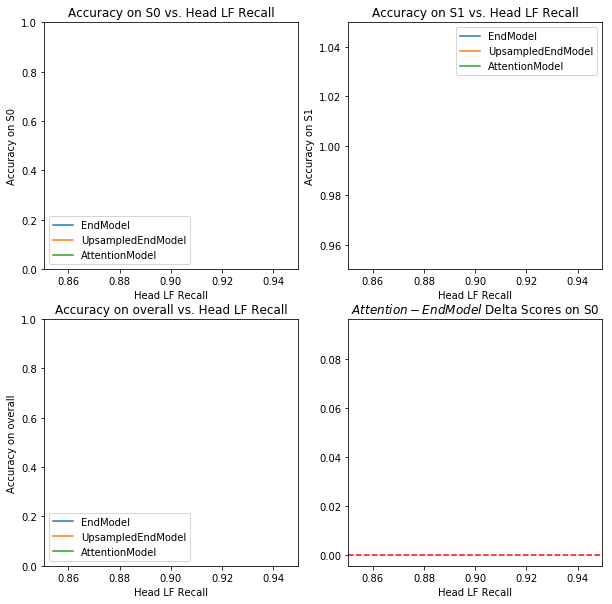

In [25]:
plot_slice_scores(scores, xlabel="Head LF Recall", custom_ylims={'S1': [0.95, 1.05]})

## Vary Head LF Recall

In [ ]:
from simulate import simulate, experiment_config
config['accs'] = np.array(accs)
experiment_config['use_weak_labels_from_gen_model'] = False
# experiment_config['x_var'] = None
experiment_config['x_var'] = 'head_recall'
# experiment_config['x_range'] = np.linspace(0, 1, 10)
experiment_config['x_range'] = [0.9]
experiment_config['num_trials'] = 1 
experiment_config['verbose'] = False
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 40
experiment_config['plot_predictions'] = ['EndModel', 'AttentionModel']

experiment_config['seed'] = 111
scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores

In [ ]:
plot_slice_scores(scores, xlabel="Head LF Recall", custom_ylims={'S1': [0.95, 1.05]})

## Vary Head LF Precision

In [ ]:
experiment_config['num_trials'] = 5
experiment_config['x_var'] = 'head_precision'
experiment_config['x_range'] = np.linspace(0.5, 1, 10)
experiment_config['plot_predictions'] = ['EndModel', 'AttentionModel']

scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores

In [ ]:
plot_slice_scores(scores, xlabel="Head LF Precision", 
                  custom_ylims={'S0': [0.90, 1.05],
                                'S1': [0.90, 1.05]})

## Vary Slice Proportion

In [ ]:
experiment_config['num_trials'] = 5 
experiment_config['x_var'] = 'slice_proportion'
experiment_config['x_range'] = np.linspace(0.01, 0.3, 10)
scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores

In [ ]:
plot_slice_scores(scores, xlabel="Slice Proportion", custom_ylims={'S1': [0.95, 1.05]})